## Mapping the US and World Coronavirus deaths as of ___
## November 6th, 2021


In [1]:
import folium
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline  

### United States Map

In [2]:
# Import the population data
df_us_pop = pd.read_excel('apportionment-2020-tableA.xlsx', header=4)
df_us_pop = df_us_pop.rename(columns={'Unnamed: 0':'State'})
df_us_pop = df_us_pop[['State', '2020 Census Resident Population']].rename( \
                            columns={'2020 Census Resident Population':'Residents'})
total_pop_us = df_us_pop[df_us_pop['State'] == 'U.S. Total']['Residents'].item()
df_us_pop = df_us_pop[df_us_pop['State'] != 'U.S. Total']
df_us_pop = df_us_pop[df_us_pop['State'] != 'U.S. Total and Puerto Rico']
df_us_pop = df_us_pop[:-1]
df_us_pop = df_us_pop[df_us_pop['State']!='Hawaii']

# Import the covid deaths data
df_us_deaths = pd.read_csv('CDC_United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
df_us_deaths = df_us_deaths[['submission_date', 'state', 'tot_death']]
df_us_deaths = df_us_deaths.groupby('state').max('submission_date')
total_deaths_us = sum(df_us_deaths['tot_death'])
df_us_deaths.loc['NY'] = df_us_deaths.loc['NY'] + df_us_deaths.loc['NYC']
df_us_deaths = df_us_deaths.drop(['NYC', 'HI', 'AK'])
df_us_deaths = df_us_deaths.reset_index()

# Import file to map state names with state abbreviations
df_abb = pd.read_csv('state abbreviations.csv')

# Import shapefile for the United States
geo_df = gpd.read_file('./gadm36_USA_shp/gadm36_USA_1.shp')
geo_df = geo_df[['NAME_1', 'geometry']]

In [3]:
# Verify one polygon per state in the shapefile
print(geo_df['NAME_1'].nunique())
print(geo_df['NAME_1'].count())

51
51


In [4]:
# Merge data sources
df_us_deaths = df_us_deaths.merge(df_abb, 
                                   left_on='state', 
                                   right_on='Abbreviation', 
                                   how='inner')
df_us = df_us_deaths.merge(df_us_pop, 
                           left_on='State', 
                           right_on='State', 
                           how='left')
geo_df = geo_df.merge(df_us, 
                       left_on='NAME_1', 
                       right_on='State', 
                       how='left') 
geo_df = geo_df.dropna()

In [5]:
# Calculate Death Rates

# Calculate for the US total (includes all numbers, not just 48 contiguous states on the map)
print('The total population of the United States is: ', '{:,}'.format(int(total_pop_us)))
print(f"There have been {'{:,}'.format(total_deaths_us)} COVID deaths since ___")
print('1 in', 
      round(1 / (total_deaths_us / total_pop_us)), 
      'residents of the United States have died since ___ ')

# Calculate deaths by state for the map
geo_df['1 in X'] = round(1 / (geo_df['tot_death'] / geo_df['Residents'])).astype('int64')
geo_df['X-1 odds'] = 1 / geo_df['1 in X']
geo_df['Deaths'] = '1 in ' + geo_df['1 in X'].astype('int64').astype(str)
geo_df = geo_df[['State', 'Residents', 'tot_death', 'Deaths', 'X-1 odds', '1 in X', 'geometry']]
geo_df['Residents'] = geo_df['Residents'].astype('int64').apply('{:,}'.format)
geo_df['tot_death'] = geo_df['tot_death'].astype('int64').apply('{:,}'.format)

The total population of the United States is:  331,449,281
There have been 751,765 COVID deaths since ___
1 in 441 residents of the United States have died since ___ 


[]

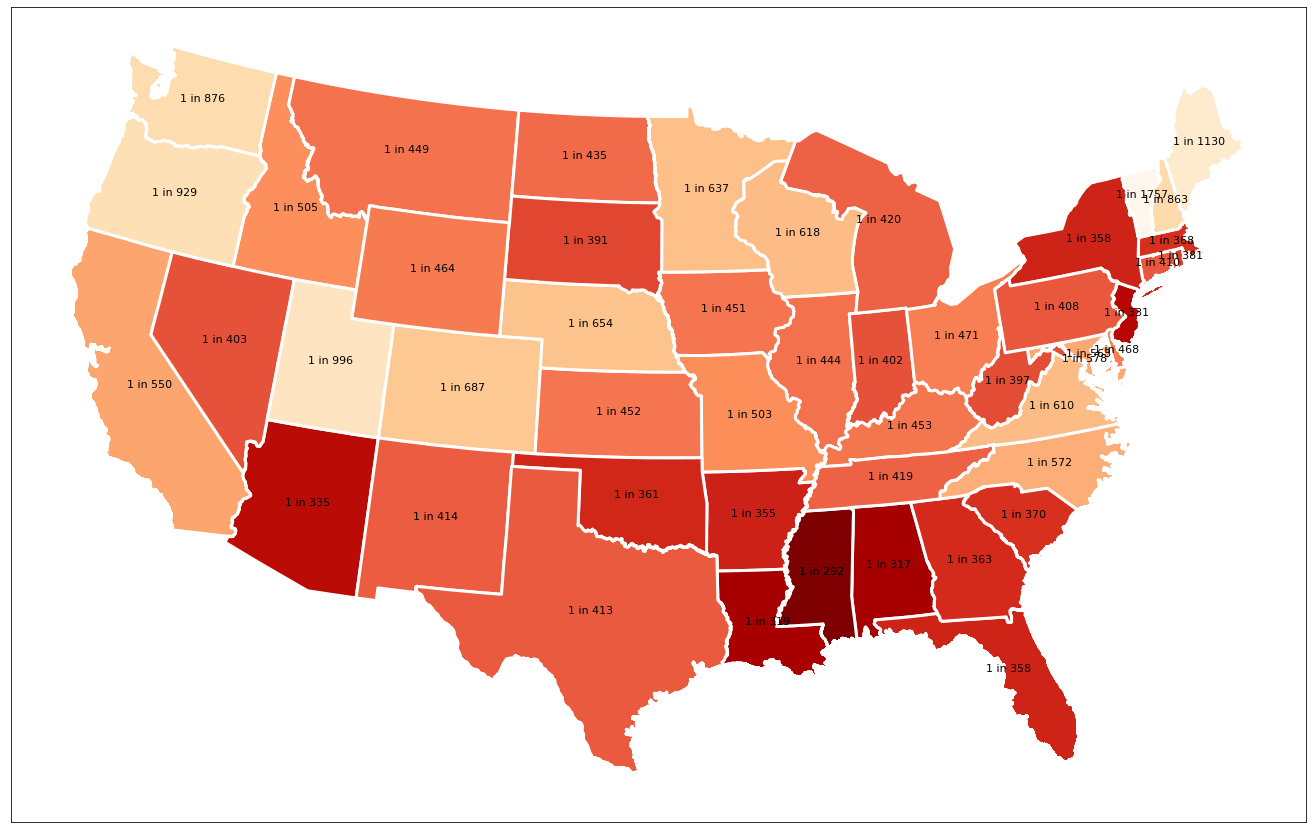

In [6]:
# Map the results with a Geopandas Choropleth map

# The Conus Albers projection provides that nice curve on the Canadian border
geo_df = geo_df.to_crs("EPSG:5070") 

ax = geo_df.plot(figsize=(25, 15), 
                 column='X-1 odds', 
                 legend=False,
                 cmap='OrRd',
                 edgecolor='white', 
                 linewidth=3,)
geo_df.apply(lambda x: ax.annotate(text=x['Deaths'], 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha='center',
                                   size=11),
             axis=1)
# ax.set_title('Total Coronavirus Deaths as of September 2021\n', size=25)
ax.set_xticks([])
ax.set_yticks([])

In [7]:
# Output the DataFrame table for a picture and then also a CSV to link to in the article
print_geo_df = geo_df[['State', 'Residents', 'tot_death', 'Deaths', '1 in X']].set_index('State')
print_geo_df = print_geo_df.rename(columns={'tot_death': 'Total Deaths'}).sort_values('1 in X')
print_geo_df[['Residents', 'Total Deaths', 'Deaths']].to_csv('data_US_2021.csv')

### World Map 

In [8]:
# Analyze the country ID number for renaming
# world = pd.read_csv('WHO COVID-19 global table data September 18th 2021 at 4.18.33 PM.csv')
# pd.options.display.max_rows=None
# world

In [9]:
# The data source is https://covid19.who.int/table?tableChartType=heat
# Remove the extra comma at the end of row two before importing
world = pd.read_csv('WHO COVID-19 global table data November 6th 2021 at 8.18.46 PM.csv')
total_world_deaths = world['Deaths - cumulative total'][0]
total_world_pop = 100000 * world['Deaths - cumulative total'][0] /\
                  world['Deaths - cumulative total per 100000 population'][0]

# Rename countries to match shapefile
world.at[5, 'Name'] = 'Russia'
world.at[4, 'Name'] = 'United Kingdom'
world.at[8, 'Name'] = 'Iran'
world.at[47, 'Name'] = 'Vietnam'
world.at[57, 'Name'] = 'Bolivia'
world.at[72, 'Name'] = 'Venezuela'
world.at[81, 'Name'] = 'Moldova'
world.at[79, 'Name'] = 'South Korea'
world.at[97, 'Name'] = 'Kosovo'
world.at[139, 'Name'] = 'Syria'
world.at[148, 'Name'] = 'East Timor'
world.at[152, 'Name'] = 'Laos'
world.at[162, 'Name'] = 'Republic of the Congo'
world.at[185, 'Name'] = 'Brunei'
world.at[206, 'Name'] = 'Tanzania'
world.at[213, 'Name'] = 'Northern Mariana Islands'
world.at[214, 'Name'] = 'Falkland Islands'
world.at[227, 'Name'] = 'North Korea'

In [10]:
geo_world = gpd.read_file('./WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')
geo_world = geo_world[['NAME_EN', 'geometry']]

# Rename countries to match the world data from WHO
geo_world.at[8, 'NAME_EN'] = 'China'
geo_world.at[46, 'NAME_EN'] = 'Czechia'
geo_world.at[59, 'NAME_EN'] = 'North Macedonia'
geo_world.at[92, 'NAME_EN'] = 'Côte d’Ivoire'
geo_world.at[119, 'NAME_EN'] = 'Eswatini'
geo_world.at[160, 'NAME_EN'] = 'Gambia'
geo_world.at[172, 'NAME_EN'] = 'Bahamas'
geo_world.at[222, 'NAME_EN'] = 'Micronesia (Federated States of)'

In [11]:
# Shapefile validation check, will need to remove duplicates in output DataFrame
print(geo_world['NAME_EN'].nunique())
print(geo_world['NAME_EN'].count())

238
251


In [12]:
# Merge data sources
world = world.merge(geo_world, 
                       left_on='Name', 
                       right_on='NAME_EN', 
                       how='left',
                       indicator=True) 
world = world.dropna()

In [13]:
# Calculate deaths per population
world = world.assign(population = 100000 *\
                     world['Deaths - cumulative total'] /\
                     world['Deaths - cumulative total per 100000 population'])
world = world[['Name', 'Deaths - cumulative total', 'population', 'geometry']]
world = world[world['Deaths - cumulative total']>0]
world = world[world['Name'] != 'Other']

# Calculate Death Rates
world_one_in = round(1 / (total_world_deaths / total_world_pop))

# Calculate for the World total
print('The total population of the World is: ',  '{:,}'.format(int(total_world_pop)))
print(f"There have been {'{:,}'.format(total_world_deaths)} COVID deaths since ___")
print('1 in', world_one_in, 'people in the World have died since ___ ')

# Calculate deaths by country for the map
world['1 in X'] = round(1 / (world['Deaths - cumulative total'] /\
                             world['population'])).astype('int64')
world['X-1 odds'] = 1 / world['1 in X']
world['Deaths'] = '1 in ' + world['1 in X'].astype('int64').astype(str)

The total population of the World is:  7,794,540,358
There have been 5,027,183 COVID deaths since ___
1 in 1550 people in the World have died since ___ 


[]

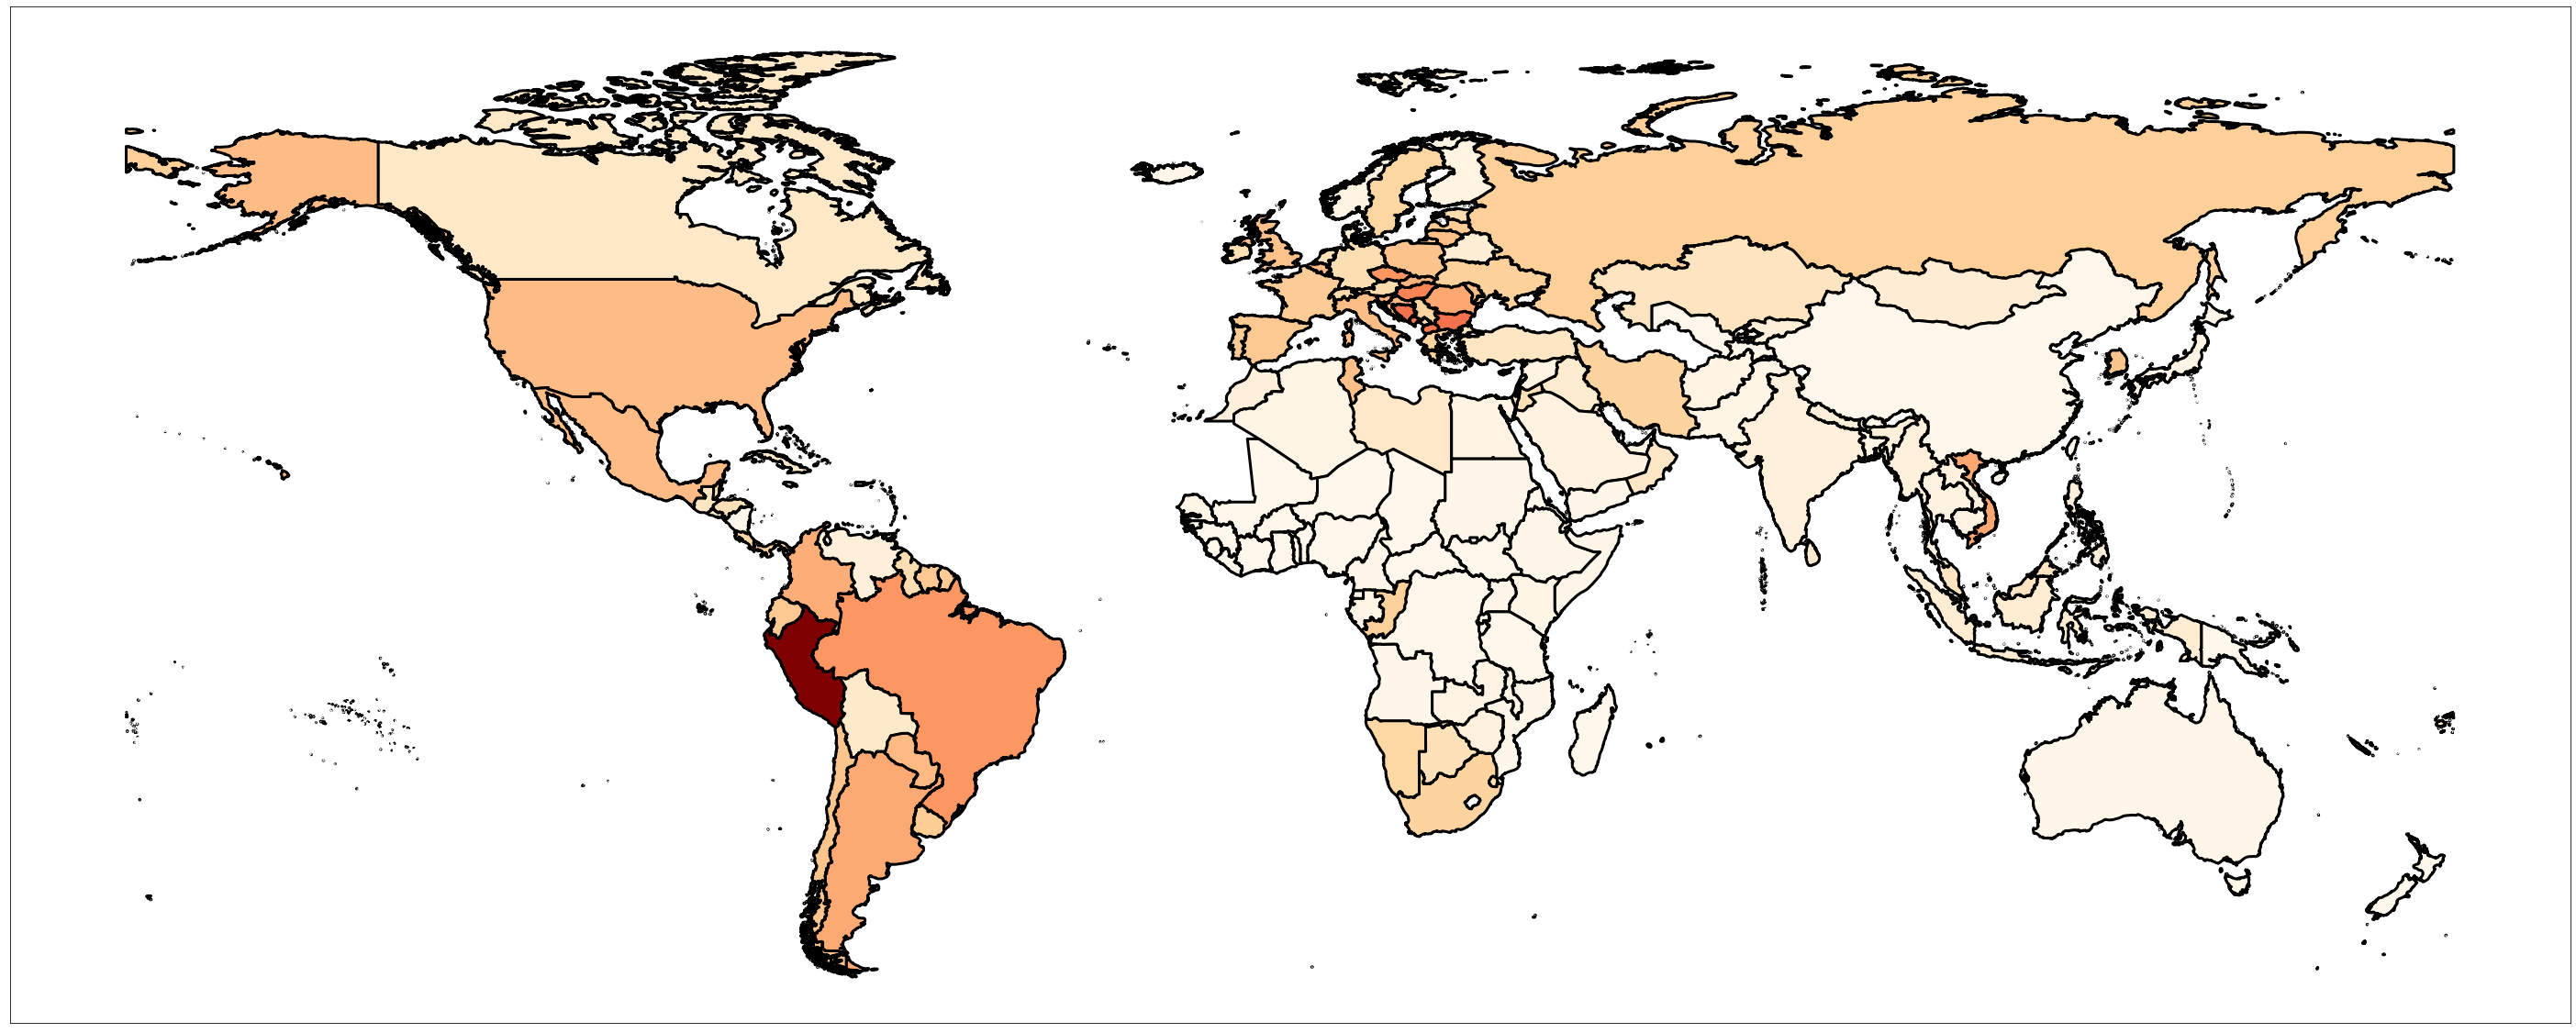

In [14]:
# Map the results with a Geopandas Choropleth map
gdf_world = gpd.GeoDataFrame(world)
ax2 = gdf_world.plot(figsize=(50, 30), 
                 column='X-1 odds', 
                 legend=False,
                 cmap='OrRd',
                 #cmap='RdPu',
                 edgecolor='black', 
                 linewidth=3)
# ax2.set_title('Total Coronavirus Deaths as of September 2021\n', size=25)
ax2.set_xticks([])
ax2.set_yticks([])

In [15]:
# rename the countries column, formatting on the numbers
world_df = world[['Name', 'population', 'Deaths - cumulative total', 'Deaths', '1 in X']]
world_df = world_df.rename(columns={'Name': 'Country',
                                   'Deaths - cumulative total': 'Total Deaths',
                                   'population': 'Population'})
world_df['Total Deaths'] = world_df['Total Deaths'].apply('{:,}'.format)
world_df['Population'] = world_df['Population'].astype('int64').apply('{:,}'.format)
world_df = world_df.drop_duplicates()
world_df = world_df.sort_values('1 in X').set_index('Country')
world_df[['Population', 'Total Deaths', 'Deaths']].to_csv('data_WORLD_2021.csv')

In [16]:
pd.set_option('max_rows', None)
world_df

,Population,Total Deaths,Deaths,1 in X
Country,,,,
Peru,"32,971,836","200,326",1 in 165,165
Bosnia and Herzegovina,"3,280,813","11,717",1 in 280,280
Bulgaria,"6,951,484","24,755",1 in 281,281
North Macedonia,"2,083,381","7,194",1 in 290,290
Montenegro,"628,062","2,119",1 in 296,296
Hungary,"9,769,515","31,184",1 in 313,313
Brunei,"33,690",98,1 in 344,344
Czechia,"10,693,941","30,938",1 in 346,346
Brazil,"212,559,584","608,235",1 in 349,349
